# London's New Hospital

## Intro

This is a suppplementary notebook containing the code for my IBM Data Science Professional Certificate. Please view report or presentation for more details.

#### Background
Given the rapidly growing and aging population, the need in hospitals is as high as it ever was. This notion is exceptionally prevalent in the developed countries, such as United Kingdom. While designing a new location for a hospital, one must consider multiple factors to determine whether it is reasonable to put a new establishment in a given location. 

##### Problem
United Kingdom’s National Health Service (NHS) has decided to put a new hospital in London. However, it wants to choose a location of this new hospital in a way that maximizes the amount of patients’ needs satisfied in the city. 
What are the best-suited boroughs in London to host the new hospital?

#### Interest
Although this is just a simulation scenario, in a real-world example NHS-like entities are indeed interested in the skills of a data scientist to decide the optimal location for their venues.


### Importing libraries and dependancies

In [2]:
import bs4 as bs
import urllib.request
import pandas as pd
import numpy as np
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  10.28 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  37.55 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  44.06 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.33 MB/s


In [4]:
import math
from geopy import distance
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Fetching the data and constructing primary data frame

The primary dataset consists of 32 rows and 10 columns. Each row represent 1 borough of London. Given that the hospitals are rare when looked at a neighborhood level, I have chosen to work with boroughs instead.

In [5]:
# requesting data from webpage
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_London_boroughs').read()
soup = bs.BeautifulSoup(source,'lxml')

# finding a table
table = soup.find('table')
table_rows = table.find_all('tr')

# fetching table data into layered list
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.split('\n')[0].split('/')[0].split(' [')[0] for tr in td]
    if len(row) > 0 and row[1] != 'Not assigned':
        l.append(row)
df = pd.DataFrame(l, 
                  columns = ['Borough', 'Inner','Royal','Local Authority','Political Control',
                             'HQ','Area(sq. miles)', 'Population', 'Location', 'Position'])

In [6]:
df.head()

,Borough,Inner,Royal,Local Authority,Political Control,HQ,Area(sq. miles),Population,Location,Position
0,Barking and Dagenham,,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,"194,352",51°33′39″N 0°09′21″E﻿,25
1,Barnet,,,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,"369,088",51°37′31″N 0°09′06″W﻿,31
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,"236,687",51°27′18″N 0°09′02″E﻿,23
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,"317,264",51°33′32″N 0°16′54″W﻿,12
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,"317,899",51°24′14″N 0°01′11″E﻿,20


### Let's do some initial pre-processing

For our analysis, we wouldn't need much of the data provided by Wikipedia. The data we would use consists of:
   1. Borough Name
   2. Population density (thousand per km^2)
   3. Coordinates
   4. Later we would also calculate the distance to the nearest hospital, but that data would be added on a later stage

In [7]:
# checking the data types
df.dtypes

Borough              object
Inner                object
Royal                object
Local Authority      object
Political Control    object
HQ                   object
Area(sq. miles)      object
Population           object
Location             object
Position             object
dtype: object

In [8]:
# Not all columns are of correct data type. Changing types
def replace_comma(x):
    return x.replace(',','')

df['Population'] = df.apply(lambda row: replace_comma(row['Population']), axis=1)

df[['Area(sq. miles)', 'Population']] = df[['Area(sq. miles)','Population']].astype('float64')

In [9]:
df.dtypes

Borough               object
Inner                 object
Royal                 object
Local Authority       object
Political Control     object
HQ                    object
Area(sq. miles)      float64
Population           float64
Location              object
Position              object
dtype: object

In [10]:
df['Area(km^2)'] = df['Area(sq. miles)'] * 2.58998811
df['Population Density'] = df['Population']/df['Area(sq. miles)']

# Location coordinates are in DMS format. we need to transform it into the decimal format using formula 
# Decimal Degrees = degrees + (minutes/60) + (seconds/3600)
df['Latitude'] = df.apply(lambda row: row['Location'].split(' ')[0], axis=1)
df['Latitude'] = df.apply(lambda row: int(row['Latitude'].split('°')[0]) + 
                          int(row['Latitude'].split('°')[1].split('′')[0])/60 + 
                          int(row['Latitude'].split('′')[1].split('″')[0])/3600, axis =1)
df['Longitude'] = df.apply(lambda row: row['Location'].split(' ')[1], axis=1)
df['Longitude'] = df.apply(lambda row: int(row['Longitude'].split('°')[0]) + 
                          int(row['Longitude'].split('°')[1].split('′')[0])/60 + 
                          int(row['Longitude'].split('′')[1].split('″')[0])/3600, axis =1)
df['Longitude'] = df.apply(lambda row: row['Longitude'] * -1 if row['Location'].split(' ')[1].split('″')[1][0] == 'W' else row['Longitude'], axis =1)
df['Radii'] = df.apply(lambda row: int(math.sqrt(row['Area(km^2)'])/math.pi * 1000), axis=1)
df.head()

,Borough,Inner,Royal,Local Authority,Political Control,HQ,Area(sq. miles),Population,Location,Position,Area(km^2),Population Density,Latitude,Longitude,Radii
0,Barking and Dagenham,,,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352.0,51°33′39″N 0°09′21″E﻿,25,36.078534,13952.045944,51.560833,0.155833,1911
1,Barnet,,,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088.0,51°37′31″N 0°09′06″W﻿,31,86.738702,11020.842042,51.625278,-0.151667,2964
2,Bexley,,,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687.0,51°27′18″N 0°09′02″E﻿,23,60.553922,10123.481608,51.455000,0.150556,2476
3,Brent,,,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264.0,51°33′32″N 0°16′54″W﻿,12,43.252801,18997.844311,51.558889,-0.281667,2093
4,Bromley,,,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899.0,51°24′14″N 0°01′11″E﻿,20,150.141611,5483.853717,51.403889,0.019722,3900


In [11]:
# constructing a new df consisting only of relevant data
numerical_df = df[['Borough', 'Population', 'Area(km^2)','Population Density', 'Radii','Latitude','Longitude']]
print(numerical_df.shape)
numerical_df.head()

(32, 7)


,Borough,Population,Area(km^2),Population Density,Radii,Latitude,Longitude
0,Barking and Dagenham,194352.0,36.078534,13952.045944,1911,51.560833,0.155833
1,Barnet,369088.0,86.738702,11020.842042,2964,51.625278,-0.151667
2,Bexley,236687.0,60.553922,10123.481608,2476,51.455000,0.150556
3,Brent,317264.0,43.252801,18997.844311,2093,51.558889,-0.281667
4,Bromley,317899.0,150.141611,5483.853717,3900,51.403889,0.019722


### Visualizing our dataset using Folium

At the first step of the analysis, I visualized the map of London and put markers signifying boroughs over them. This was done using folium library (DMS coordinates were transformed to decimal coordinates)

In [12]:
boroughs = numerical_df
london_latitude = 51.509865
london_longitude = -0.118092

# create map of london using latitude and longitude values
map_london = folium.Map(location=[london_latitude, london_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, population in zip(boroughs['Latitude'], boroughs['Longitude'], boroughs['Borough'], boroughs['Population']):
    label = '{}, {}'.format(borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)
map_london

### Fetching hospital data from Foursquare
This visualization does not provide enough information per se. Although now we know the general location of boroughs, that is not enough to make any assumptions about which boroughs are better suited as places for new hospital.

Using Foursquare API I have fetched information on hospital within the limits of a borough. To simplify this process I’ve calculated the distance from a center of each borough using its area as a perfect circle and finding a radius of that circle. 

In [13]:
# Here I actually used my foursquare login and secret, but you will see a spoof data cause I don't really want to show them

CLIENT_ID = 'Q0V0GNJIWCQ53W3BGMNV2QHYVIWDQBHQGA025BOXXBFX22U3' # your Foursquare ID
CLIENT_SECRET = 'RTTS43XX3TLFW4ETYZQEUKFT3H20T01HNX2QFJSO1HWI1OG4' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = '100'

def getNearbyVenues(names, latitudes, longitudes, radii):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d196941735'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# for simplicity sake we are getting only one neighborhood per postal code
london_data = numerical_df

london_venues = getNearbyVenues(names=london_data['Borough'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude'],
                                 radii = london_data['Radii']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [15]:
print(london_venues.shape[0])
print(len(london_venues['Venue'].unique()))

141
135


#### Now that we have the list of venues, we can pre-process it in order to cluster our boroughs

In [16]:
london_venues.dtypes

Borough               object
Borough Latitude     float64
Borough Longitude    float64
Venue                 object
Venue Latitude       float64
Venue Longitude      float64
Venue Category        object
dtype: object

In [17]:
#Let's calculate mean distance to hospitals for each borough
import geopy
london_venues['Distance'] = london_venues.apply(lambda row: distance.vincenty((row['Borough Latitude'],row['Borough Longitude']),
                                                                         (row['Venue Latitude'],row['Venue Longitude'])).m, axis=1)

In [18]:
london_venues_data = pd.DataFrame(data=[london_venues.groupby('Borough').count()['Venue'],
                                        london_venues.groupby('Borough').mean()['Distance']])

In [19]:
london_venues_data = london_venues_data.transpose()

In [20]:
london_venues_data.reset_index(inplace=True)

In [21]:
print(london_venues_data.shape)
print(london_data.shape)

(29, 3)
(32, 7)


#### As we can see, not all boroughs had any hospitals nearby. Let's see what those boroughs are

In [22]:
set(london_data['Borough'].tolist()).symmetric_difference(set(london_venues_data['Borough'].tolist()))

{'Bexley', 'Haringey', 'Redbridge'}

#### Now we delete boroughs without hospitals and merge lists

In [23]:

new_data = london_data.drop(london_data[(london_data.Borough == 'Bexley') | (london_data.Borough == 'Haringey') | (london_data.Borough == 'Redbridge')].index)
new_data = new_data.join(london_venues_data.set_index('Borough'), on='Borough')

new_data.head()

,Borough,Population,Area(km^2),Population Density,Radii,Latitude,Longitude,Venue,Distance
0,Barking and Dagenham,194352.0,36.078534,13952.045944,1911,51.560833,0.155833,6.0,1733.905443
1,Barnet,369088.0,86.738702,11020.842042,2964,51.625278,-0.151667,3.0,2608.249590
3,Brent,317264.0,43.252801,18997.844311,2093,51.558889,-0.281667,4.0,1268.875489
4,Bromley,317899.0,150.141611,5483.853717,3900,51.403889,0.019722,3.0,3063.734702
5,Camden,229719.0,21.755900,27347.500000,1484,51.528889,-0.125556,23.0,977.221576


Now we can see much more. As expected, many hospitals are located within Inner London, most notably Camden borough. On the other hand, it looks that there are boroughs, especially on the outskirts, that are fully devoid of hospitals. Those boroughs may be primary targets for new hospitals.
Looking closer into the dataset fetched from Foursquare we can confirm that boroughs of Bexley, Haringey, and Redbridge lack any hospitals and therefore are the prime targets for a new one.

This may have concluded this analysis, but let’s say that maybe the contractor is more interested in locations that already have some hospitals, but generally not enough. To understand which boroughs among those that have hospitals are the best for a new one, there must be additional pre-processing of data.

First, we add the overall amount of hospitals for each borough, adding ‘Venue’ column.


In [24]:
# let's see how the values are correlated
corr = new_data[['Population','Area(km^2)','Population Density','Venue','Distance']].corr()
corr.style.background_gradient(cmap='coolwarm')


,Population,Area(km^2),Population Density,Venue,Distance
Population,1,0.442095,-0.175389,-0.113649,0.415593
Area(km^2),0.442095,1,-0.794263,-0.156613,0.774874
Population Density,-0.175389,-0.794263,1,0.106996,-0.751027
Venue,-0.113649,-0.156613,0.106996,1,-0.103462
Distance,0.415593,0.774874,-0.751027,-0.103462,1


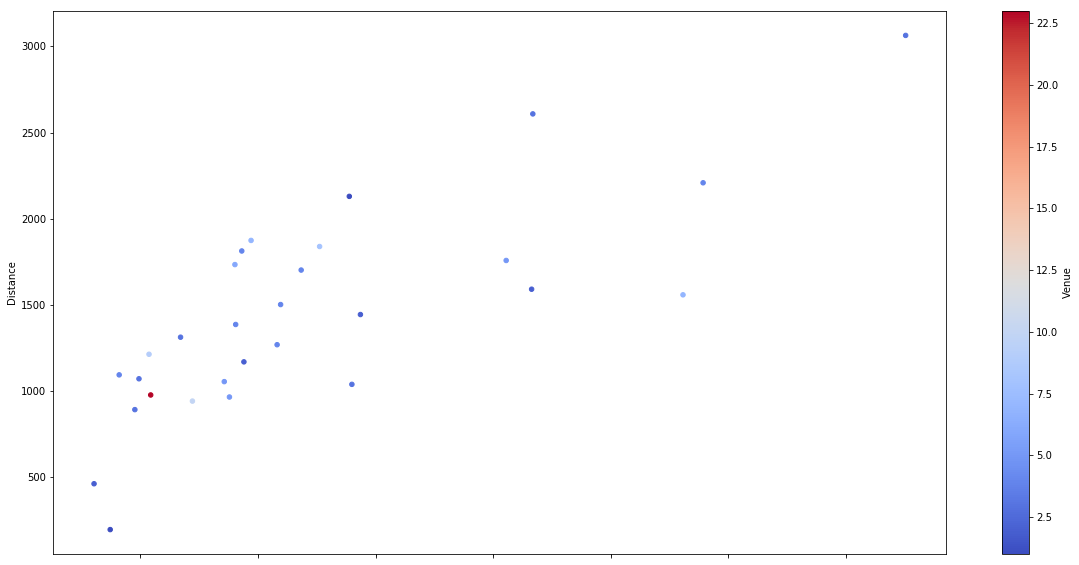

In [25]:
# A scatterplot of the most correlated values: distance and area

new_data.plot.scatter(x='Area(km^2)',
                      y='Distance',
                      c='Venue',
                      colormap='coolwarm',
                     figsize = (20,10))

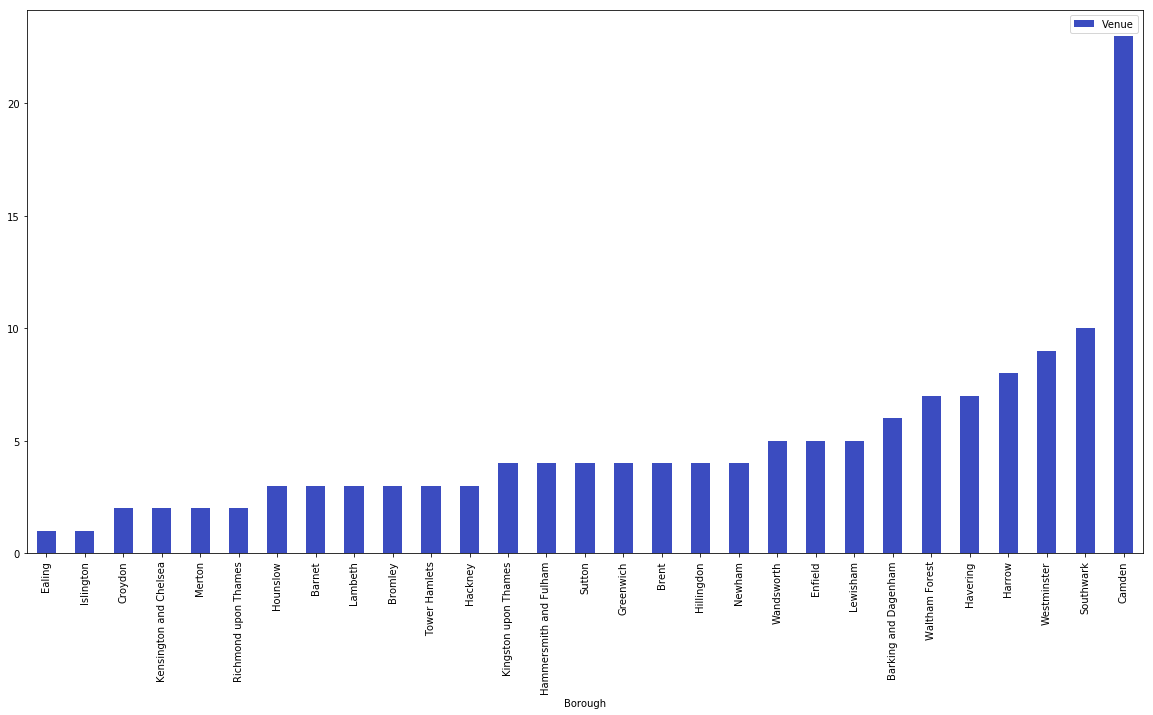

In [26]:
new_data.sort_values(by=['Venue']).plot.bar(x='Borough',
                  y='Venue',
                  figsize= (20,10), colormap = 'coolwarm')

### Let's put hospitals on our london map

In [27]:
# create map of london using latitude and longitude values
map_london2 = folium.Map(location=[london_latitude, london_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, population in zip(boroughs['Latitude'], boroughs['Longitude'], boroughs['Borough'], boroughs['Population']):
    label = '{}, {}'.format(borough, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london2)

for lat, lng, venue in zip(london_venues['Venue Latitude'], london_venues['Venue Longitude'], london_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london2)
    
    

map_london2

### Clustering data

The next step is clustering analysis. I decided to use k-means clustering, as it is a regional clustering model that works well with the task of segmenting data into general, non-overlapping clusters.

The first step, data normalization, was done using StandardScaler() of skit-learn library. k of 4 was chosen after testing model with different values. The model KMeans() has clustered dataset into 4 clusters with distinct characteristics

In [28]:
# set number of clusters
kclusters = 4

london_data_clustering = new_data[['Population','Venue','Area(km^2)','Distance']]

scaler = StandardScaler()
scaler.fit(london_data_clustering)
scaler.transform(london_data_clustering)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_data_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 3, 1, 1, 0, 3, 3, 1, 0, 0, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 2, 0, 0, 1, 0], dtype=int32)

In [29]:
full_data = new_data
full_data['Label'] = kmeans.labels_

In [38]:
full_data.groupby('Label').mean()[['Population', 'Venue', 'Distance']]

,Population,Venue,Distance
Label,,,
0,251610.333333,7.444444,1351.802184
1,307791.333333,4.777778,1551.043282
2,187699.125000,3.125000,1176.745913
3,361444.666667,2.000000,2109.650791


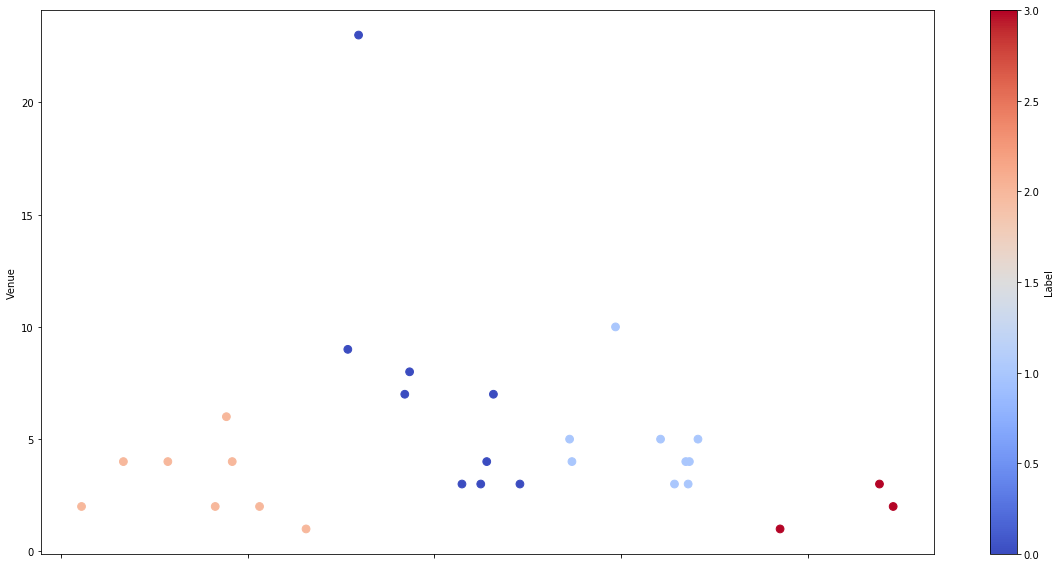

In [31]:
# The clusters are most clearly separated by their population

full_data.plot.scatter(x='Population',
                       y='Venue',
                       c='Label',
                       colormap = 'coolwarm',
                       s = 60,
                       figsize = (20,10))


Cluster 3 is clearly the most suitable for a new hospital, as boroughs in it has the largest population, the least venues and the longest distance between hospitals. Three boroughs constitute cluster 3: Croydon, Ealing, and Barnet. We would recommend those boroughs as locations for a new hospital.

As a final step, we color our marks on the map in different colors, according to their clusters. Cluster 3 is colored red.


In [32]:
# create map
map_clusters = folium.Map(location=[london_latitude, london_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+3 + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(full_data['Latitude'], full_data['Longitude'], full_data['Borough'], full_data['Label']):    
        
        marker = int(cluster) 
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[marker],
            fill=True,
            fill_color=rainbow[marker],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Results

The question posed before this analysis was what are the best-suited boroughs in London to host the new hospital?

After conducting data analysis, I have concluded that the most sutable boroughs are Bexley, Haringey, and Redbridge as they completely lack any hospital venues. However, if it is more desired to put a new hospital at a location that already hosts a hospital, then Croydon, Ealing, and Barnet are the optimal boroughs for that. Camden is the most overpopulated borough in terms of hospitals.
### Discussion
It should be noted that all of the boroughs that lack sufficient hospitals are located far from the center of London, which may hint at the fact that more attention should be averted to the suburban areas. 

Another point of concern is disproportionate number of hospitals in Camden borough. Even compared to other Inner London boroughs it has twice more the amount of hospitals, which may lead to potential logistics issues within the neighborhoods of that borough.

More data would be necessary to make this analysis more accurate. In particular, given the demographics (age and social), rate of accidents and crime rate of each borough may give additional insight towards what locations require additional hospitals. 
### Conclusions
In conclusion I would like to thank my instructors and fellow learners that have helped me immensely on this journey of getting familiar with the data science. Data science has really grown onto me over the time it took me to finish this specializations and I am eager to apply my knowledge on practice and learn more.
